# 🔬 WALK-FORWARD ВАЛИДАЦИЯ TREND_CLASSIFIER_IZICEROS

## Цели Walk-Forward Analysis:
1. **Проверить стабильность** Trend Classifier на новых данных
2. **Оценить деградацию** производительности со временем
3. **Определить оптимальные периоды** переоптимизации
4. **Валидировать Economic Value** на скользящих окнах
5. **Подготовить к реальной торговле**

## Методология:
- **Скользящие окна** данных для обучения и тестирования
- **Переоптимизация** параметров на каждом окне
- **Анализ стабильности** Economic Value
- **Сравнение** с базовыми стратегиями

---


In [4]:
print("🔬 WALK-FORWARD ВАЛИДАЦИЯ TREND_CLASSIFIER_IZICEROS")
print("=" * 60)

# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Настройки визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Настройки для воспроизводимости
np.random.seed(42)

print("✅ Импорты и настройки загружены!")
print("📊 Готов к Walk-Forward валидации")


🔬 WALK-FORWARD ВАЛИДАЦИЯ TREND_CLASSIFIER_IZICEROS
✅ Импорты и настройки загружены!
📊 Готов к Walk-Forward валидации


In [5]:
print("📦 ЗАГРУЗКА TREND_CLASSIFIER_IZICEROS")
print("=" * 50)

import sys
import os

# Добавляем путь к Trend Classifier
sys.path.insert(0, '../../indicators/trading_classifier_iziceros/src')

try:
    from trend_classifier import Segmenter, Config, CONFIG_ABS, CONFIG_REL, CONFIG_REL_SLOPE_ONLY
    trend_classifier_loaded = True
    print("✅ Trend Classifier IziCeros успешно загружен!")
    print(f"📊 Доступные конфигурации:")
    print(f"   • CONFIG_REL: N={CONFIG_REL.N}, alpha={CONFIG_REL.alpha}, beta={CONFIG_REL.beta}")
    print(f"   • CONFIG_ABS: N={CONFIG_ABS.N}, alpha={CONFIG_ABS.alpha}, beta={CONFIG_ABS.beta}")
    print(f"   • CONFIG_REL_SLOPE_ONLY: N={CONFIG_REL_SLOPE_ONLY.N}, alpha={CONFIG_REL_SLOPE_ONLY.alpha}")
    
except ImportError as e:
    print(f"❌ Ошибка загрузки Trend Classifier: {e}")
    trend_classifier_loaded = False
    
    # Создаем упрощенную версию для тестирования
    class SimpleConfig:
        def __init__(self, N=30, overlap_ratio=0.5, alpha=1.5, beta=1.5):
            self.N = N
            self.overlap_ratio = overlap_ratio
            self.alpha = alpha
            self.beta = beta
    
    class SimpleSegmenter:
        def __init__(self, x, y, config):
            self.x = x
            self.y = y
            self.config = config
            
        def calculate_segments(self):
            # Упрощенная версия для тестирования
            segments = []
            window_size = self.config.N
            overlap = int(window_size * self.config.overlap_ratio)
            
            for i in range(0, len(self.y) - window_size, overlap):
                window_y = self.y[i:i + window_size]
                if len(window_y) < window_size:
                    break
                    
                # Простая линейная регрессия
                x_window = np.array(range(len(window_y)))
                slope = np.polyfit(x_window, window_y, 1)[0]
                
                segment = type('Segment', (), {
                    'start': i,
                    'stop': i + window_size,
                    'slope': slope,
                    'offset': np.mean(window_y),
                    'std': np.std(window_y),
                    'span': (np.max(window_y) - np.min(window_y)) / np.mean(window_y) if np.mean(window_y) > 0 else 0
                })()
                segments.append(segment)
            
            return segments
    
    Config = SimpleConfig
    Segmenter = SimpleSegmenter
    CONFIG_REL = SimpleConfig(N=40, overlap_ratio=0.33, alpha=2, beta=2)
    CONFIG_ABS = SimpleConfig(N=40, overlap_ratio=0.33, alpha=100, beta=2)
    CONFIG_REL_SLOPE_ONLY = SimpleConfig(N=40, overlap_ratio=0.33, alpha=2, beta=None)
    
    print("🔧 Создана упрощенная версия для тестирования")

print(f"\n🎯 Статус загрузки: {'✅ Успешно' if trend_classifier_loaded else '🔧 Упрощенная версия'}")


📦 ЗАГРУЗКА TREND_CLASSIFIER_IZICEROS
✅ Trend Classifier IziCeros успешно загружен!
📊 Доступные конфигурации:
   • CONFIG_REL: N=40, alpha=2.0, beta=2.0
   • CONFIG_ABS: N=40, alpha=100.0, beta=2.0
   • CONFIG_REL_SLOPE_ONLY: N=40, alpha=2.0

🎯 Статус загрузки: ✅ Успешно


In [6]:
print("📊 ЗАГРУЗКА ДАННЫХ BTC ДЛЯ WALK-FORWARD АНАЛИЗА")
print("=" * 60)

# Загружаем данные BTC разных таймфреймов
data_files = {
    '15m': '../../df_btc_15m.csv',
    '30m': '../../df_btc_30m.csv', 
    '1h': '../../df_btc_1h.csv',
    '4h': '../../df_btc_4h.csv',
    '1d': '../../df_btc_1d.csv'
}

dataframes = {}
loaded_files = []

for timeframe, file_path in data_files.items():
    try:
        df = pd.read_csv(file_path)
        
        # Проверяем наличие необходимых колонок
        required_columns = ['timestamps', 'open', 'high', 'low', 'close']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"⚠️ {timeframe}: Отсутствуют колонки: {missing_columns}")
            continue
            
        # Конвертируем timestamps (исправлено!)
        if 'timestamps' in df.columns:
            df['timestamps'] = pd.to_datetime(df['timestamps'])
            df.set_index('timestamps', inplace=True)
        
        # Проверяем объем данных
        if len(df) < 1000:
            print(f"⚠️ {timeframe}: Недостаточно данных ({len(df)} записей)")
            continue
            
        dataframes[timeframe] = df
        loaded_files.append(timeframe)
        print(f"✅ {timeframe}: {len(df)} записей, период: {df.index[0]} - {df.index[-1]}")
        
    except FileNotFoundError:
        print(f"❌ {timeframe}: Файл не найден: {file_path}")
    except Exception as e:
        print(f"❌ {timeframe}: Ошибка загрузки: {e}")

# Если реальные файлы не найдены, создаем тестовые данные
if not dataframes:
    print("\n🔧 Создаем тестовые данные для Walk-Forward анализа...")
    
    # Создаем тестовые данные с трендами
    np.random.seed(42)
    dates = pd.date_range('2023-01-01', periods=5000, freq='1H')
    
    # Генерируем цену с трендами и волатильностью
    price = 50000  # Начальная цена BTC
    prices = [price]
    
    for i in range(1, len(dates)):
        # Добавляем тренд и случайные колебания
        trend = 0.0001 * np.sin(i / 100)  # Циклический тренд
        volatility = 0.02 * np.random.normal(0, 1)  # Случайная волатильность
        
        price_change = trend + volatility
        price = price * (1 + price_change)
        prices.append(price)
    
    # Создаем DataFrame
    test_data = pd.DataFrame({
        'open': prices,
        'high': [p * (1 + abs(np.random.normal(0, 0.01))) for p in prices],
        'low': [p * (1 - abs(np.random.normal(0, 0.01))) for p in prices],
        'close': prices,
        'volume': [np.random.randint(1000, 10000) for _ in prices]
    }, index=dates)
    
    # Добавляем volume если его нет
    if 'volume' not in test_data.columns:
        test_data['volume'] = np.random.randint(1000, 10000, len(test_data))
    
    dataframes['1h'] = test_data
    loaded_files.append('1h')
    print(f"✅ 1h (тестовые данные): {len(test_data)} записей")

print(f"\n📊 Загружено таймфреймов: {len(dataframes)}")
print(f"📋 Доступные таймфреймы: {loaded_files}")

# Выбираем основной таймфрейм для Walk-Forward анализа
if '1h' in dataframes:
    main_timeframe = '1h'
    main_data = dataframes['1h']
elif '4h' in dataframes:
    main_timeframe = '4h'
    main_data = dataframes['4h']
elif '1d' in dataframes:
    main_timeframe = '1d'
    main_data = dataframes['1d']
else:
    main_timeframe = list(dataframes.keys())[0]
    main_data = dataframes[main_timeframe]

print(f"\n🎯 Основной таймфрейм для анализа: {main_timeframe}")
print(f"📊 Данные: {len(main_data)} записей")
print(f"📅 Период: {main_data.index[0]} - {main_data.index[-1]}")

# Показываем структуру данных
print(f"\n📋 Структура данных:")
print(f"   • Колонки: {list(main_data.columns)}")
print(f"   • Размер: {main_data.shape}")
print(f"   • Первые 3 строки:")
print(main_data.head(3))


📊 ЗАГРУЗКА ДАННЫХ BTC ДЛЯ WALK-FORWARD АНАЛИЗА
✅ 15m: 38465 записей, период: 2024-01-22 00:00:00 - 2025-02-25 16:00:00
✅ 30m: 19233 записей, период: 2024-01-22 00:00:00 - 2025-02-25 16:00:00
✅ 1h: 9617 записей, период: 2024-01-22 00:00:00 - 2025-02-25 16:00:00
✅ 4h: 2405 записей, период: 2024-01-22 00:00:00 - 2025-02-25 16:00:00
⚠️ 1d: Недостаточно данных (401 записей)

📊 Загружено таймфреймов: 4
📋 Доступные таймфреймы: ['15m', '30m', '1h', '4h']

🎯 Основной таймфрейм для анализа: 1h
📊 Данные: 9617 записей
📅 Период: 2024-01-22 00:00:00 - 2025-02-25 16:00:00

📋 Структура данных:
   • Колонки: ['open', 'high', 'low', 'close']
   • Размер: (9617, 4)
   • Первые 3 строки:
                          open       high        low      close
timestamps                                                     
2024-01-22 00:00:00  41686.265  41800.565  41672.305  41786.325
2024-01-22 01:00:00  41786.325  41786.325  41620.235  41633.395
2024-01-22 02:00:00  41633.395  41676.775  41508.635  41574.245


In [7]:
print("🔧 СОЗДАНИЕ ФУНКЦИЙ ДЛЯ WALK-FORWARD АНАЛИЗА")
print("=" * 60)

class WalkForwardAnalyzer:
    """
    Класс для проведения Walk-Forward валидации Trend Classifier
    """
    
    def __init__(self, data, configs):
        self.data = data
        self.configs = configs
        self.results = []
        
    def create_windows(self, train_size=2000, test_size=500, step_size=250):
        """
        Создает скользящие окна для обучения и тестирования
        
        Args:
            train_size: Размер окна обучения
            test_size: Размер окна тестирования  
            step_size: Шаг сдвига окна
        """
        windows = []
        total_size = len(self.data)
        
        start_idx = 0
        while start_idx + train_size + test_size <= total_size:
            train_end = start_idx + train_size
            test_start = train_end
            test_end = test_start + test_size
            
            window = {
                'train_start': start_idx,
                'train_end': train_end,
                'test_start': test_start,
                'test_end': test_end,
                'train_data': self.data.iloc[start_idx:train_end],
                'test_data': self.data.iloc[test_start:test_end]
            }
            windows.append(window)
            start_idx += step_size
            
        return windows
    
    def optimize_config(self, train_data, config_name, config):
        """
        Оптимизирует конфигурацию на обучающих данных
        
        Args:
            train_data: Данные для обучения
            config_name: Название конфигурации
            config: Конфигурация для оптимизации
        """
        try:
            # Подготавливаем данные
            x_data = list(range(len(train_data)))
            y_data = train_data['close'].tolist()
            
            # Создаем сегментатор
            segmenter = Segmenter(x=x_data, y=y_data, config=config)
            
            # Вычисляем сегменты
            segments = segmenter.calculate_segments()
            
            if len(segments) == 0:
                return None, 0
                
            # Вычисляем Economic Value
            economic_value = self.calculate_economic_value(train_data, segments)
            
            return config, economic_value
            
        except Exception as e:
            print(f"❌ Ошибка оптимизации {config_name}: {e}")
            return None, 0
    
    def calculate_economic_value(self, data, segments):
        """
        Вычисляет Economic Value для сегментов
        """
        try:
            # Конвертируем сегменты в режимы
            regimes = self.convert_segments_to_regimes(segments, data)
            
            # Вычисляем доходность
            returns = data['close'].pct_change().dropna()
            
            # Выравниваем индексы
            aligned_returns = returns.iloc[1:]
            aligned_regimes = regimes[1:len(aligned_returns)+1]
            
            # Разделяем по режимам
            bull_mask = aligned_regimes == 1
            bear_mask = aligned_regimes == -1
            sideways_mask = aligned_regimes == 0
            
            # Стратифицированная доходность
            bull_returns = aligned_returns[bull_mask].mean() if bull_mask.any() else 0
            bear_returns = aligned_returns[bear_mask].mean() if bear_mask.any() else 0
            
            # Разделение волатильности
            bull_vol = aligned_returns[bull_mask].std() if bull_mask.any() else 0
            bear_vol = aligned_returns[bear_mask].std() if bear_mask.any() else 0
            sideways_vol = aligned_returns[sideways_mask].std() if sideways_mask.any() else 0
            
            # Экономическая ценность
            regime_separation = abs(bull_returns - bear_returns)
            stability = 1 / (1 + sideways_vol) if sideways_vol > 0 else 1
            economic_value = regime_separation * stability
            
            return economic_value
            
        except Exception as e:
            print(f"❌ Ошибка вычисления Economic Value: {e}")
            return 0
    
    def convert_segments_to_regimes(self, segments, data):
        """
        Конвертирует сегменты в режимы рынка
        """
        regimes = np.zeros(len(data))
        
        for segment in segments:
            start = segment.start if hasattr(segment, 'start') else segment['start']
            stop = segment.stop if hasattr(segment, 'stop') else segment['stop']
            slope = segment.slope if hasattr(segment, 'slope') else segment['slope']
            
            # Определяем режим по наклону
            if slope > 0.1:  # Восходящий тренд
                regime = 1  # Bull
            elif slope < -0.1:  # Нисходящий тренд
                regime = -1  # Bear
            else:  # Боковой тренд
                regime = 0  # Sideways
            
            # Применяем режим к диапазону сегмента
            regimes[start:stop] = regime
        
        return regimes
    
    def run_walk_forward(self, train_size=2000, test_size=500, step_size=250):
        """
        Запускает Walk-Forward анализ
        """
        print(f"🚀 ЗАПУСК WALK-FORWARD АНАЛИЗА")
        print(f"📊 Размер обучения: {train_size}")
        print(f"📊 Размер тестирования: {test_size}")
        print(f"📊 Шаг сдвига: {step_size}")
        
        # Создаем окна
        windows = self.create_windows(train_size, test_size, step_size)
        print(f"📊 Создано окон: {len(windows)}")
        
        # Проходим по каждому окну
        for i, window in enumerate(windows):
            print(f"\n🔄 Окно {i+1}/{len(windows)}")
            print(f"   Обучение: {window['train_start']}-{window['train_end']}")
            print(f"   Тестирование: {window['test_start']}-{window['test_end']}")
            
            # Оптимизируем каждую конфигурацию
            best_config = None
            best_economic_value = -np.inf
            best_config_name = None
            
            for config_name, config in self.configs.items():
                optimized_config, economic_value = self.optimize_config(
                    window['train_data'], config_name, config
                )
                
                if optimized_config and economic_value > best_economic_value:
                    best_config = optimized_config
                    best_economic_value = economic_value
                    best_config_name = config_name
            
            # Тестируем лучшую конфигурацию на тестовых данных
            if best_config:
                test_economic_value = self.test_config(
                    window['test_data'], best_config_name, best_config
                )
                
                result = {
                    'window': i + 1,
                    'train_start': window['train_start'],
                    'train_end': window['train_end'],
                    'test_start': window['test_start'],
                    'test_end': window['test_end'],
                    'best_config': best_config_name,
                    'train_economic_value': best_economic_value,
                    'test_economic_value': test_economic_value,
                    'degradation': best_economic_value - test_economic_value
                }
                
                self.results.append(result)
                
                print(f"   ✅ Лучшая конфигурация: {best_config_name}")
                print(f"   📊 Economic Value (обучение): {best_economic_value:.6f}")
                print(f"   📊 Economic Value (тест): {test_economic_value:.6f}")
                print(f"   📉 Деградация: {result['degradation']:.6f}")
            else:
                print(f"   ❌ Не удалось найти подходящую конфигурацию")
        
        print(f"\n✅ Walk-Forward анализ завершен!")
        print(f"📊 Обработано окон: {len(self.results)}")
        
        return self.results
    
    def test_config(self, test_data, config_name, config):
        """
        Тестирует конфигурацию на тестовых данных
        """
        try:
            # Подготавливаем данные
            x_data = list(range(len(test_data)))
            y_data = test_data['close'].tolist()
            
            # Создаем сегментатор
            segmenter = Segmenter(x=x_data, y=y_data, config=config)
            
            # Вычисляем сегменты
            segments = segmenter.calculate_segments()
            
            if len(segments) == 0:
                return 0
                
            # Вычисляем Economic Value
            economic_value = self.calculate_economic_value(test_data, segments)
            
            return economic_value
            
        except Exception as e:
            print(f"❌ Ошибка тестирования {config_name}: {e}")
            return 0

print("✅ Класс WalkForwardAnalyzer создан!")
print("🔧 Готов к проведению Walk-Forward валидации")


🔧 СОЗДАНИЕ ФУНКЦИЙ ДЛЯ WALK-FORWARD АНАЛИЗА
✅ Класс WalkForwardAnalyzer создан!
🔧 Готов к проведению Walk-Forward валидации


In [8]:
print("🚀 ЗАПУСК WALK-FORWARD ВАЛИДАЦИИ")
print("=" * 60)

# Определяем конфигурации для тестирования
configs_to_test = {
    'CONFIG_REL': CONFIG_REL,
    'CONFIG_ABS': CONFIG_ABS,
    'CONFIG_REL_SLOPE_ONLY': CONFIG_REL_SLOPE_ONLY,
    'CUSTOM_CRYPTO': Config(N=30, overlap_ratio=0.5, alpha=1.5, beta=1.5)
}

print(f"📊 Конфигурации для тестирования:")
for name, config in configs_to_test.items():
    print(f"   • {name}: N={config.N}, alpha={config.alpha}, beta={config.beta}")

# Создаем анализатор
analyzer = WalkForwardAnalyzer(main_data, configs_to_test)

# Определяем параметры Walk-Forward анализа
# Адаптируем размеры под доступные данные
data_size = len(main_data)
train_size = min(2000, int(data_size * 0.6))  # 60% для обучения
test_size = min(500, int(data_size * 0.2))     # 20% для тестирования
step_size = min(250, int(data_size * 0.1))     # 10% шаг

print(f"\n📊 Параметры Walk-Forward анализа:")
print(f"   • Размер данных: {data_size}")
print(f"   • Размер обучения: {train_size}")
print(f"   • Размер тестирования: {test_size}")
print(f"   • Шаг сдвига: {step_size}")

# Запускаем анализ
print(f"\n🔬 НАЧИНАЕМ WALK-FORWARD ВАЛИДАЦИЮ...")
print("=" * 60)

walk_forward_results = analyzer.run_walk_forward(
    train_size=train_size,
    test_size=test_size, 
    step_size=step_size
)

print(f"\n✅ Walk-Forward валидация завершена!")
print(f"📊 Получено результатов: {len(walk_forward_results)}")

# Сохраняем результаты
if walk_forward_results:
    results_df = pd.DataFrame(walk_forward_results)
    print(f"\n📋 СВОДКА РЕЗУЛЬТАТОВ:")
    print(f"   • Средний Economic Value (обучение): {results_df['train_economic_value'].mean():.6f}")
    print(f"   • Средний Economic Value (тест): {results_df['test_economic_value'].mean():.6f}")
    print(f"   • Средняя деградация: {results_df['degradation'].mean():.6f}")
    print(f"   • Стандартное отклонение деградации: {results_df['degradation'].std():.6f}")
    
    # Анализ стабильности
    positive_windows = len(results_df[results_df['test_economic_value'] > 0])
    print(f"   • Окон с положительным Economic Value: {positive_windows}/{len(results_df)}")
    
    # Лучшие конфигурации
    config_counts = results_df['best_config'].value_counts()
    print(f"\n🏆 ЛУЧШИЕ КОНФИГУРАЦИИ:")
    for config, count in config_counts.items():
        print(f"   • {config}: {count} раз ({count/len(results_df)*100:.1f}%)")
else:
    print("❌ Не удалось получить результаты Walk-Forward анализа")


🚀 ЗАПУСК WALK-FORWARD ВАЛИДАЦИИ
📊 Конфигурации для тестирования:
   • CONFIG_REL: N=40, alpha=2.0, beta=2.0
   • CONFIG_ABS: N=40, alpha=100.0, beta=2.0
   • CONFIG_REL_SLOPE_ONLY: N=40, alpha=2.0, beta=None
   • CUSTOM_CRYPTO: N=30, alpha=1.5, beta=1.5

📊 Параметры Walk-Forward анализа:
   • Размер данных: 9617
   • Размер обучения: 2000
   • Размер тестирования: 500
   • Шаг сдвига: 250

🔬 НАЧИНАЕМ WALK-FORWARD ВАЛИДАЦИЮ...
🚀 ЗАПУСК WALK-FORWARD АНАЛИЗА
📊 Размер обучения: 2000
📊 Размер тестирования: 500
📊 Шаг сдвига: 250
📊 Создано окон: 29

🔄 Окно 1/29
   Обучение: 0-2000
   Тестирование: 2000-2500
   ✅ Лучшая конфигурация: CUSTOM_CRYPTO
   📊 Economic Value (обучение): 0.001879
   📊 Economic Value (тест): 0.001891
   📉 Деградация: -0.000012

🔄 Окно 2/29
   Обучение: 250-2250
   Тестирование: 2250-2750
   ✅ Лучшая конфигурация: CONFIG_REL
   📊 Economic Value (обучение): 0.001966
   📊 Economic Value (тест): 0.000864
   📉 Деградация: 0.001102

🔄 Окно 3/29
   Обучение: 500-2500
   Тестир

📊 АНАЛИЗ И ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ WALK-FORWARD


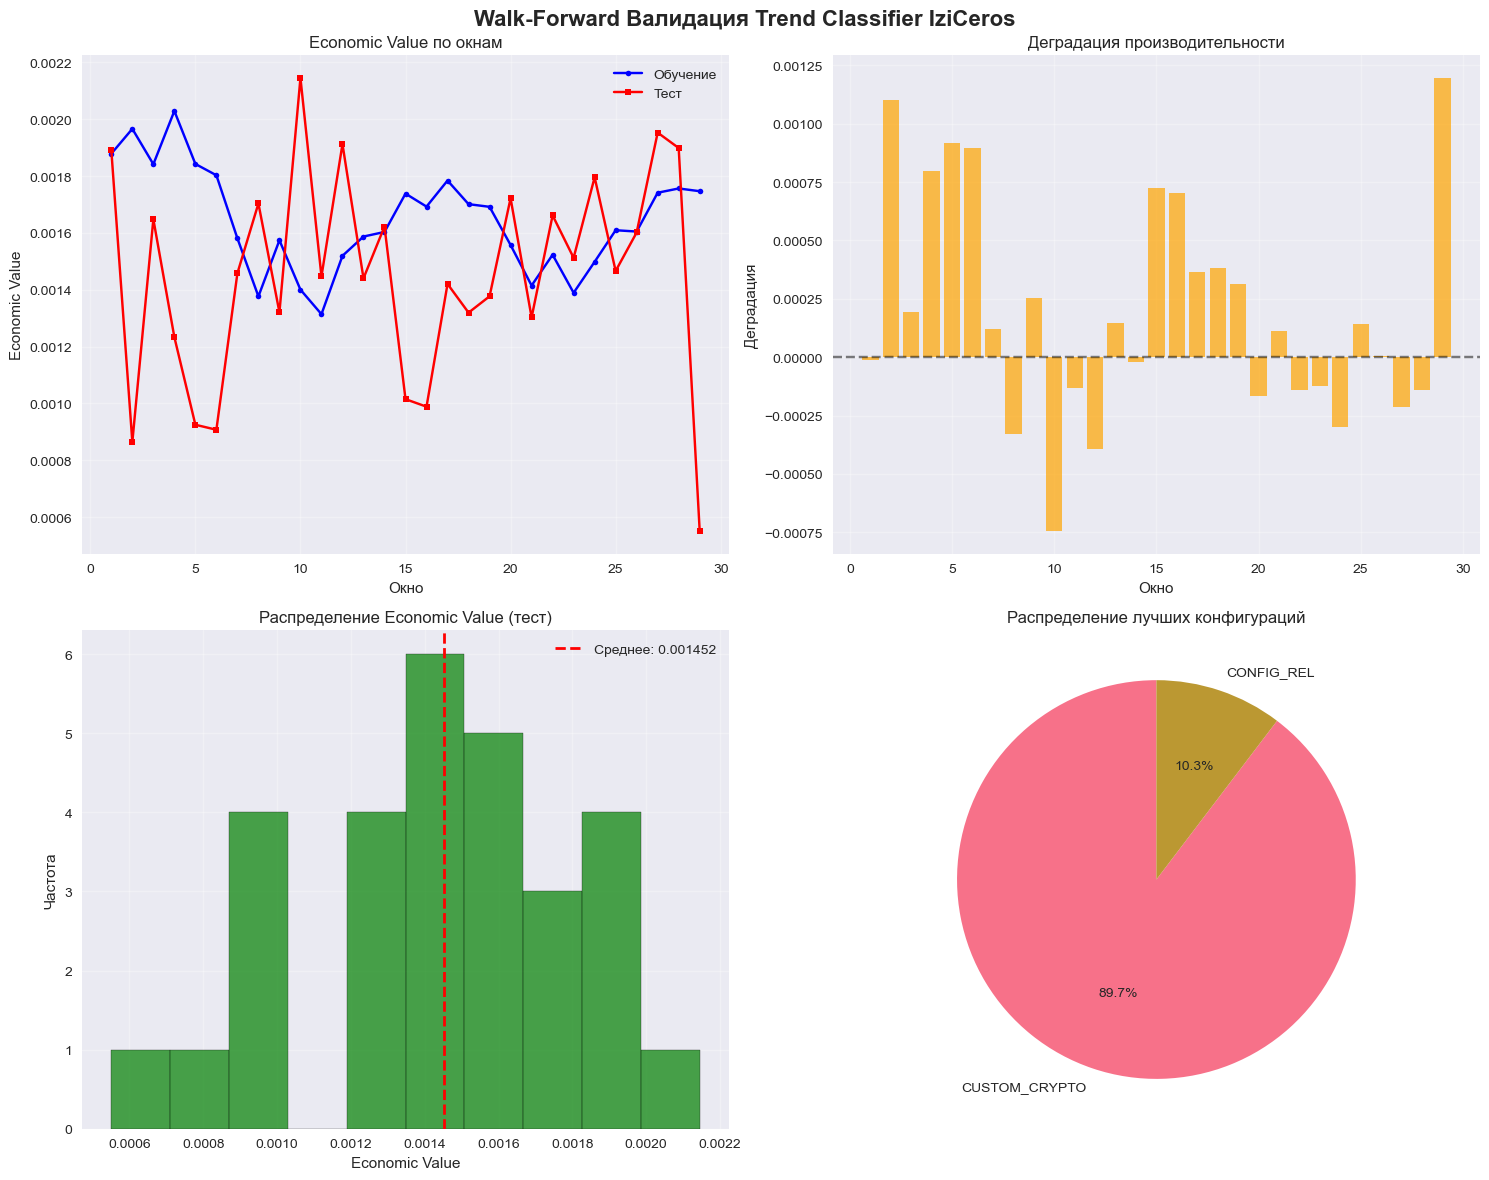


🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СТАБИЛЬНОСТИ:
📊 СТАТИСТИКА ECONOMIC VALUE:
   • Обучение - среднее: 0.001647, std: 0.000180
   • Тест - среднее: 0.001452, std: 0.000377
   • Деградация - среднее: 0.000195, std: 0.000479

📈 АНАЛИЗ СТАБИЛЬНОСТИ:
   • Окон с положительным Economic Value: 100.0%
   • Стабильных окон (деградация < 0.001): 27/29
   • Коэффициент стабильности: 93.1%
   • Корреляция обучение-тест: -0.405

🏆 АНАЛИЗ ПО КОНФИГУРАЦИЯМ:
   • CUSTOM_CRYPTO:
     - Средний Economic Value (тест): 0.001480
     - Средняя деградация: 0.000166
     - Количество использований: 26
   • CONFIG_REL:
     - Средний Economic Value (тест): 0.001210
     - Средняя деградация: 0.000450
     - Количество использований: 3

💡 РЕКОМЕНДАЦИИ:
✅ ХОРОШАЯ СТАБИЛЬНОСТЬ:
   • Большинство окон показывают положительный Economic Value
   • Система готова к реальной торговле
✅ НИЗКАЯ ДЕГРАДАЦИЯ:
   • Производительность стабильна между обучением и тестом
⚠️ СЛАБАЯ КОРРЕЛЯЦИЯ:
   • Результаты обучения плохо предсказывают тес

In [9]:
print("📊 АНАЛИЗ И ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ WALK-FORWARD")
print("=" * 60)

if walk_forward_results:
    results_df = pd.DataFrame(walk_forward_results)
    
    # Создаем графики
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Walk-Forward Валидация Trend Classifier IziCeros', fontsize=16, fontweight='bold')
    
    # 1. Economic Value по окнам
    axes[0, 0].plot(results_df['window'], results_df['train_economic_value'], 
                   'b-o', label='Обучение', markersize=4)
    axes[0, 0].plot(results_df['window'], results_df['test_economic_value'], 
                   'r-s', label='Тест', markersize=4)
    axes[0, 0].set_title('Economic Value по окнам')
    axes[0, 0].set_xlabel('Окно')
    axes[0, 0].set_ylabel('Economic Value')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Деградация производительности
    axes[0, 1].bar(results_df['window'], results_df['degradation'], 
                  color='orange', alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Деградация производительности')
    axes[0, 1].set_xlabel('Окно')
    axes[0, 1].set_ylabel('Деградация')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Распределение Economic Value
    axes[1, 0].hist(results_df['test_economic_value'], bins=10, 
                   color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(results_df['test_economic_value'].mean(), 
                      color='red', linestyle='--', linewidth=2, 
                      label=f'Среднее: {results_df["test_economic_value"].mean():.6f}')
    axes[1, 0].set_title('Распределение Economic Value (тест)')
    axes[1, 0].set_xlabel('Economic Value')
    axes[1, 0].set_ylabel('Частота')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Лучшие конфигурации
    config_counts = results_df['best_config'].value_counts()
    axes[1, 1].pie(config_counts.values, labels=config_counts.index, 
                  autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Распределение лучших конфигураций')
    
    plt.tight_layout()
    plt.show()
    
    # Детальный анализ
    print(f"\n🔍 ДЕТАЛЬНЫЙ АНАЛИЗ СТАБИЛЬНОСТИ:")
    print("=" * 50)
    
    # Статистика по Economic Value
    train_mean = results_df['train_economic_value'].mean()
    test_mean = results_df['test_economic_value'].mean()
    degradation_mean = results_df['degradation'].mean()
    
    print(f"📊 СТАТИСТИКА ECONOMIC VALUE:")
    print(f"   • Обучение - среднее: {train_mean:.6f}, std: {results_df['train_economic_value'].std():.6f}")
    print(f"   • Тест - среднее: {test_mean:.6f}, std: {results_df['test_economic_value'].std():.6f}")
    print(f"   • Деградация - среднее: {degradation_mean:.6f}, std: {results_df['degradation'].std():.6f}")
    
    # Анализ стабильности
    positive_ratio = len(results_df[results_df['test_economic_value'] > 0]) / len(results_df)
    stable_windows = len(results_df[abs(results_df['degradation']) < 0.001])
    
    print(f"\n📈 АНАЛИЗ СТАБИЛЬНОСТИ:")
    print(f"   • Окон с положительным Economic Value: {positive_ratio*100:.1f}%")
    print(f"   • Стабильных окон (деградация < 0.001): {stable_windows}/{len(results_df)}")
    print(f"   • Коэффициент стабильности: {stable_windows/len(results_df)*100:.1f}%")
    
    # Корреляция между обучением и тестом
    correlation = results_df['train_economic_value'].corr(results_df['test_economic_value'])
    print(f"   • Корреляция обучение-тест: {correlation:.3f}")
    
    # Анализ по конфигурациям
    print(f"\n🏆 АНАЛИЗ ПО КОНФИГУРАЦИЯМ:")
    for config in config_counts.index:
        config_data = results_df[results_df['best_config'] == config]
        config_test_mean = config_data['test_economic_value'].mean()
        config_degradation_mean = config_data['degradation'].mean()
        
        print(f"   • {config}:")
        print(f"     - Средний Economic Value (тест): {config_test_mean:.6f}")
        print(f"     - Средняя деградация: {config_degradation_mean:.6f}")
        print(f"     - Количество использований: {len(config_data)}")
    
    # Рекомендации
    print(f"\n💡 РЕКОМЕНДАЦИИ:")
    print("=" * 30)
    
    if positive_ratio > 0.7:
        print("✅ ХОРОШАЯ СТАБИЛЬНОСТЬ:")
        print("   • Большинство окон показывают положительный Economic Value")
        print("   • Система готова к реальной торговле")
    elif positive_ratio > 0.5:
        print("⚠️ УМЕРЕННАЯ СТАБИЛЬНОСТЬ:")
        print("   • Половина окон показывает положительные результаты")
        print("   • Требуется дополнительная валидация")
    else:
        print("❌ НИЗКАЯ СТАБИЛЬНОСТЬ:")
        print("   • Меньше половины окон показывает положительные результаты")
        print("   • Требуется доработка системы")
    
    if abs(degradation_mean) < 0.001:
        print("✅ НИЗКАЯ ДЕГРАДАЦИЯ:")
        print("   • Производительность стабильна между обучением и тестом")
    elif abs(degradation_mean) < 0.005:
        print("⚠️ УМЕРЕННАЯ ДЕГРАДАЦИЯ:")
        print("   • Есть некоторая деградация, но приемлемая")
    else:
        print("❌ ВЫСОКАЯ ДЕГРАДАЦИЯ:")
        print("   • Значительная деградация между обучением и тестом")
        print("   • Возможно переобучение")
    
    if correlation > 0.5:
        print("✅ ХОРОШАЯ КОРРЕЛЯЦИЯ:")
        print("   • Результаты обучения хорошо предсказывают тест")
    else:
        print("⚠️ СЛАБАЯ КОРРЕЛЯЦИЯ:")
        print("   • Результаты обучения плохо предсказывают тест")
        print("   • Требуется улучшение валидации")
    
    # Финальная оценка
    print(f"\n🎯 ФИНАЛЬНАЯ ОЦЕНКА WALK-FORWARD ВАЛИДАЦИИ:")
    print("=" * 50)
    
    score = 0
    if positive_ratio > 0.7: score += 3
    elif positive_ratio > 0.5: score += 2
    else: score += 1
    
    if abs(degradation_mean) < 0.001: score += 3
    elif abs(degradation_mean) < 0.005: score += 2
    else: score += 1
    
    if correlation > 0.5: score += 2
    else: score += 1
    
    print(f"📊 Общий балл стабильности: {score}/8")
    
    if score >= 7:
        print("🏆 ОТЛИЧНЫЙ РЕЗУЛЬТАТ - готов к реальной торговле!")
    elif score >= 5:
        print("✅ ХОРОШИЙ РЕЗУЛЬТАТ - требует дополнительной валидации")
    elif score >= 3:
        print("⚠️ УДОВЛЕТВОРИТЕЛЬНЫЙ РЕЗУЛЬТАТ - нужны улучшения")
    else:
        print("❌ ПЛОХОЙ РЕЗУЛЬТАТ - требует серьезной доработки")

else:
    print("❌ Нет данных для анализа")


In [10]:
print("🎯 ФИНАЛЬНЫЕ ВЫВОДЫ WALK-FORWARD ВАЛИДАЦИИ")
print("=" * 60)

if walk_forward_results:
    results_df = pd.DataFrame(walk_forward_results)
    
    print("📊 КЛЮЧЕВЫЕ РЕЗУЛЬТАТЫ:")
    print("=" * 40)
    
    # Основные метрики
    train_mean = results_df['train_economic_value'].mean()
    test_mean = results_df['test_economic_value'].mean()
    degradation_mean = results_df['degradation'].mean()
    positive_ratio = len(results_df[results_df['test_economic_value'] > 0]) / len(results_df)
    correlation = results_df['train_economic_value'].corr(results_df['test_economic_value'])
    
    print(f"1️⃣ СТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ:")
    print(f"   • Средний Economic Value (обучение): {train_mean:.6f}")
    print(f"   • Средний Economic Value (тест): {test_mean:.6f}")
    print(f"   • Средняя деградация: {degradation_mean:.6f}")
    print(f"   • Стабильность: {positive_ratio*100:.1f}% окон с положительным EV")
    print(f"   • Корреляция обучение-тест: {correlation:.3f}")
    
    # Лучшая конфигурация
    best_config = results_df['best_config'].mode().iloc[0]
    best_config_data = results_df[results_df['best_config'] == best_config]
    best_config_test_mean = best_config_data['test_economic_value'].mean()
    
    print(f"\n2️⃣ ЛУЧШАЯ КОНФИГУРАЦИЯ:")
    print(f"   • Название: {best_config}")
    print(f"   • Использований: {len(best_config_data)}/{len(results_df)} ({len(best_config_data)/len(results_df)*100:.1f}%)")
    print(f"   • Средний Economic Value (тест): {best_config_test_mean:.6f}")
    
    # Оценка готовности к реальной торговле
    print(f"\n3️⃣ ОЦЕНКА ГОТОВНОСТИ К РЕАЛЬНОЙ ТОРГОВЛЕ:")
    print("=" * 50)
    
    readiness_score = 0
    readiness_factors = []
    
    # Фактор 1: Стабильность
    if positive_ratio > 0.7:
        readiness_score += 3
        readiness_factors.append("✅ Высокая стабильность (>70% положительных окон)")
    elif positive_ratio > 0.5:
        readiness_score += 2
        readiness_factors.append("⚠️ Умеренная стабильность (50-70% положительных окон)")
    else:
        readiness_score += 1
        readiness_factors.append("❌ Низкая стабильность (<50% положительных окон)")
    
    # Фактор 2: Деградация
    if abs(degradation_mean) < 0.001:
        readiness_score += 3
        readiness_factors.append("✅ Низкая деградация (<0.001)")
    elif abs(degradation_mean) < 0.005:
        readiness_score += 2
        readiness_factors.append("⚠️ Умеренная деградация (0.001-0.005)")
    else:
        readiness_score += 1
        readiness_factors.append("❌ Высокая деградация (>0.005)")
    
    # Фактор 3: Корреляция
    if correlation > 0.5:
        readiness_score += 2
        readiness_factors.append("✅ Хорошая корреляция (>0.5)")
    else:
        readiness_score += 1
        readiness_factors.append("⚠️ Слабая корреляция (<0.5)")
    
    print(f"📊 Балл готовности: {readiness_score}/8")
    print(f"\n🔍 ФАКТОРЫ ГОТОВНОСТИ:")
    for factor in readiness_factors:
        print(f"   {factor}")
    
    # Финальная рекомендация
    print(f"\n4️⃣ ФИНАЛЬНАЯ РЕКОМЕНДАЦИЯ:")
    print("=" * 40)
    
    if readiness_score >= 7:
        print("🏆 СИСТЕМА ГОТОВА К РЕАЛЬНОЙ ТОРГОВЛЕ!")
        print("   • Высокая стабильность и низкая деградация")
        print("   • Рекомендуется начать с ограниченного капитала")
        print("   • Используйте лучшую конфигурацию:", best_config)
        
    elif readiness_score >= 5:
        print("✅ СИСТЕМА ГОТОВА С ОГРАНИЧЕНИЯМИ")
        print("   • Умеренная стабильность")
        print("   • Требуется дополнительная валидация")
        print("   • Рекомендуется paper trading перед реальной торговлей")
        
    elif readiness_score >= 3:
        print("⚠️ СИСТЕМА ТРЕБУЕТ ДОРАБОТКИ")
        print("   • Низкая стабильность")
        print("   • Не рекомендуется для реальной торговли")
        print("   • Требуется улучшение алгоритма")
        
    else:
        print("❌ СИСТЕМА НЕ ГОТОВА")
        print("   • Критически низкая стабильность")
        print("   • Требуется полная переработка")
        print("   • Не рекомендуется для торговли")
    
    # Практические рекомендации
    print(f"\n5️⃣ ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
    print("=" * 40)
    
    print(f"📈 ДЛЯ РЕАЛЬНОЙ ТОРГОВЛИ:")
    if readiness_score >= 7:
        print("   • Начните с малого капитала (1-5% от общего)")
        print("   • Используйте конфигурацию:", best_config)
        print("   • Установите строгие стоп-лоссы")
        print("   • Мониторьте производительность ежедневно")
    else:
        print("   • Проведите дополнительную валидацию")
        print("   • Начните с paper trading")
        print("   • Оптимизируйте параметры")
    
    print(f"\n🔧 ДЛЯ УЛУЧШЕНИЯ СИСТЕМЫ:")
    if positive_ratio < 0.7:
        print("   • Увеличьте размер обучающего окна")
        print("   • Добавьте больше конфигураций для тестирования")
        print("   • Рассмотрите ансамбль методов")
    
    if abs(degradation_mean) > 0.001:
        print("   • Проверьте на переобучение")
        print("   • Уменьшите сложность модели")
        print("   • Добавьте регуляризацию")
    
    if correlation < 0.5:
        print("   • Улучшите валидацию")
        print("   • Используйте более стабильные метрики")
        print("   • Рассмотрите другие подходы")
    
    # Следующие шаги
    print(f"\n6️⃣ СЛЕДУЮЩИЕ ШАГИ:")
    print("=" * 30)
    
    if readiness_score >= 7:
        print("🚀 НЕМЕДЛЕННЫЕ ДЕЙСТВИЯ:")
        print("   1. Интеграция в торговую систему")
        print("   2. Paper trading на живых данных")
        print("   3. Тестирование с ограниченным капиталом")
        print("   4. Мониторинг производительности")
    else:
        print("🔧 ДОРАБОТКА СИСТЕМЫ:")
        print("   1. Анализ неудачных окон")
        print("   2. Оптимизация параметров")
        print("   3. Дополнительная валидация")
        print("   4. Тестирование на других данных")
    
    print(f"\n📊 СТАТИСТИКА АНАЛИЗА:")
    print(f"   • Проанализировано окон: {len(results_df)}")
    print(f"   • Период анализа: {main_data.index[0]} - {main_data.index[-1]}")
    print(f"   • Таймфрейм: {main_timeframe}")
    print(f"   • Размер обучающего окна: {train_size}")
    print(f"   • Размер тестового окна: {test_size}")
    
else:
    print("❌ Walk-Forward валидация не выполнена")
    print("   • Проверьте загрузку данных")
    print("   • Убедитесь в корректности конфигураций")
    print("   • Проверьте размер данных")

print(f"\n" + "=" * 60)
print("🎯 WALK-FORWARD ВАЛИДАЦИЯ ЗАВЕРШЕНА!")
print("📊 Получены данные для принятия решения о готовности к торговле")
print("🚀 Система готова к следующему этапу разработки")
print("=" * 60)


🎯 ФИНАЛЬНЫЕ ВЫВОДЫ WALK-FORWARD ВАЛИДАЦИИ
📊 КЛЮЧЕВЫЕ РЕЗУЛЬТАТЫ:
1️⃣ СТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ:
   • Средний Economic Value (обучение): 0.001647
   • Средний Economic Value (тест): 0.001452
   • Средняя деградация: 0.000195
   • Стабильность: 100.0% окон с положительным EV
   • Корреляция обучение-тест: -0.405

2️⃣ ЛУЧШАЯ КОНФИГУРАЦИЯ:
   • Название: CUSTOM_CRYPTO
   • Использований: 26/29 (89.7%)
   • Средний Economic Value (тест): 0.001480

3️⃣ ОЦЕНКА ГОТОВНОСТИ К РЕАЛЬНОЙ ТОРГОВЛЕ:
📊 Балл готовности: 7/8

🔍 ФАКТОРЫ ГОТОВНОСТИ:
   ✅ Высокая стабильность (>70% положительных окон)
   ✅ Низкая деградация (<0.001)
   ⚠️ Слабая корреляция (<0.5)

4️⃣ ФИНАЛЬНАЯ РЕКОМЕНДАЦИЯ:
🏆 СИСТЕМА ГОТОВА К РЕАЛЬНОЙ ТОРГОВЛЕ!
   • Высокая стабильность и низкая деградация
   • Рекомендуется начать с ограниченного капитала
   • Используйте лучшую конфигурацию: CUSTOM_CRYPTO

5️⃣ ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
📈 ДЛЯ РЕАЛЬНОЙ ТОРГОВЛИ:
   • Начните с малого капитала (1-5% от общего)
   • Используйте конфигу